In [3]:
# Define a function that generates samples approximate RGO. The target is defined in Potential class.
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import target_func, estimate_W2_Gaussian
from matplotlib.ticker import MultipleLocator 
from NUTS import nuts6

In [4]:
# Define a function as the original approximate RGO
def generate_samples(step_size, x_y, f):
    dimension = f.dimension
    ite = 0
    while True:
        samples = np.random.multivariate_normal(mean = x_y, cov = step_size * np.identity(dimension), size = 2)
        # Compute the acceptance probability
        gradient = f.firstOrder(x_y)
        a = f.zeroOrder(samples[0,:])-np.dot(gradient,samples[0,:])
        b = f.zeroOrder(samples[1,:])-np.dot(gradient,samples[1,:])
        # The code works even when rho is inf. One can also take the log transformation
        rho = np.exp(b-a)
        u = np.random.uniform(0,1)
        ite = ite + 1
        if u < rho/2:
            break
    return samples[0,:],ite

# Define a function that estimates the local step size
def estimate_step_size(step_size, tolerance, y, f):
    dimension = f.dimension
    # Compute the desired subexponential parameter
    x_y = f.solve1(y, step_size)
    testFunction = lambda C : np.mean(np.exp(np.abs(Y)**(2/(1+f.alpha))/C))-2
    while True:
        # Generate random samples from a Gaussian distribution: \exp^{-(x-x_y)^2/(2\step_size)}
        samples = np.random.multivariate_normal(mean = x_y, cov = step_size * np.identity(dimension), size = 200)
        Y = np.zeros(100)
        for i in range(100):
            gradient = f.firstOrder(x_y)
            a = f.zeroOrder(samples[i])-np.dot(gradient,samples[i])
            b = f.zeroOrder(samples[i+100])-np.dot(gradient,samples[i+100])
            Y[i] = b-a
        # Estimate the subexponential parameter of Y: find the smallest C>0 such that E[\exp^{\abs(Y)/C}] \leq 2 by binary search for smooth potentials
        # Initialize the interval
        left = 0
        right = dimension**(f.alpha/(f.alpha+1)) # The estimated upper bound of the subexponential parameter
        while testFunction(right)>0:
            left = right
            right = 2*right
        # Initialize the middle point
        mid = (left+right)/2
        # Initialize the value of the function
        f_mid = testFunction(mid)
        while abs(f_mid) > 1e-2:
            if f_mid > 0:
                left = mid
            else:
                right = mid
            mid = (left+right)/2
            f_mid =  testFunction(mid)
        # reduce this 10
        if mid < 1 / ( np.log(6/tolerance) / np.log(2)  * 0.5) :
            break
        else:
            step_size = step_size / 2
            x_y = f.solve1(y, step_size)
    return step_size, x_y

# Define the outer loop of proximal sampler
def proximal_sampler(initial_step_size, num_samples, num_iter, f, fixed):
    dimension = f.dimension

    samples = np.zeros([num_samples,num_iter,dimension])
    Ysamples = np.zeros([num_samples,dimension])
    rejections = np.zeros([num_samples, num_iter])
    step_sizes = np.zeros([num_samples,num_iter])

    
    # Initialize the samples for both fxied and adaptive versions
    diagonal_values = np.linspace(1, 2, dimension) 
    samples[:,0,:] = np.random.multivariate_normal(mean =  2 + np.zeros(dimension), cov = np.diag(diagonal_values), size = num_samples)
    for j in range(num_samples):
        Ysamples[j,:] = np.random.multivariate_normal(mean =  np.zeros(dimension), cov = np.identity(dimension), size = 1)
        if fixed == False:
            step_size, x_y = estimate_step_size(initial_step_size, 1e-2, Ysamples[j,:], f)
            step_sizes[j,0] = step_size

    
    if fixed == True:    
        print(f'fixed sampling')
        for i in range(1,num_iter):
            for j in range(num_samples):
                x_y = f.solve1(Ysamples[j,:], initial_step_size)
                samples[j,i,:],ite = generate_samples(initial_step_size, x_y, f)
                Ysamples[j,:] = np.random.multivariate_normal(mean = samples[j,i,:], cov = initial_step_size * np.identity(dimension), size = 1) 
                rejections[j,i] = ite
            if i % 100 == 0:
                print(f"Steps:{i}")
                if f.times2 > 0:
                    print(f"Averaged optimization steps of the new one: {f.ite2/f.times2}")
                print(f"Averaged rejection steps : {np.mean(rejections[:,i])}")
        
        return samples
    
    if fixed == False:
        print(f'adpative sampling')
        for i in range(1,num_iter):
            for j in range(num_samples):
                # if i < 100 or (i >= 100 and np.random.uniform(0,1) < 0.001):
                if True:
                    step_size, x_y = estimate_step_size(2*step_sizes[j,i-1], 1e-2, Ysamples[j,:], f)
                else:
                    x_y = f.solve1(Ysamples[j,:], step_sizes[j,i-1])
                    step_size = step_sizes[j,i-1]
                samples[j,i,:],ite = generate_samples(step_size, x_y, f)
                Ysamples[j,:] = np.random.multivariate_normal(mean = samples[j,i,:], cov = step_size * np.identity(dimension), size = 1)  
                step_sizes[j,i] = step_size
                rejections[j,i] = ite  
            
            # statistics for the first sample
            if i % 100 == 0:
                print(f"Steps:{i}")
                print(f"Averaged_step_size:{np.mean(step_sizes[:,i])}")
                if f.times2 > 0:
                    print(f"Averaged optimization steps of the new one: {f.ite2/f.times2}")
                print(f"Averaged rejection steps : {np.mean(rejections[:,i])}")
    return samples, step_sizes
            

dim:2, 'W2:2.8433238425554763'
dim:4, 'W2:3.9609861810416853'
dim:8, 'W2:5.769323879522842'
dim:16, 'W2:8.334689383639695'


dim:32, 'W2:11.558643091578183'
dim:2, 'W2:2.952950568994666'
dim:4, 'W2:4.003476565634921'
dim:8, 'W2:5.932835726604109'
dim:16, 'W2:8.112232796509332'
dim:32, 'W2:11.83537650093562'
dim:2, 'W2:2.931355056028143'
dim:4, 'W2:4.34047284708141'
dim:8, 'W2:5.950849916056355'
dim:16, 'W2:7.919116409804345'
dim:32, 'W2:11.51679847877132'
dim:2, 'W2:2.781796616635642'
dim:4, 'W2:3.919392228559123'
dim:8, 'W2:5.509420507960996'
dim:16, 'W2:7.904508874847297'
dim:32, 'W2:11.440911743411343'
dim:2, 'W2:3.403396799254459'
dim:4, 'W2:4.202900378476613'
dim:8, 'W2:5.7914438255365965'
dim:16, 'W2:8.534993808918225'
dim:32, 'W2:12.047737951687035'
dim:2, 'W2:2.9170582331084973'
dim:4, 'W2:4.207365008189059'
dim:8, 'W2:5.742777067833176'
dim:16, 'W2:8.310005947258567'
dim:32, 'W2:11.953001341953406'
dim:2, 'W2:3.0594324720059554'
dim:4, 'W2:4.288758529416365'
dim:8, 'W2:5.879743900545856'
dim:16, 'W2:8.271952435587073'
dim:32, 'W2:11.607318938201606'
dim:2, 'W2:2.9835890920459525'
dim:4, 'W2:4.149264

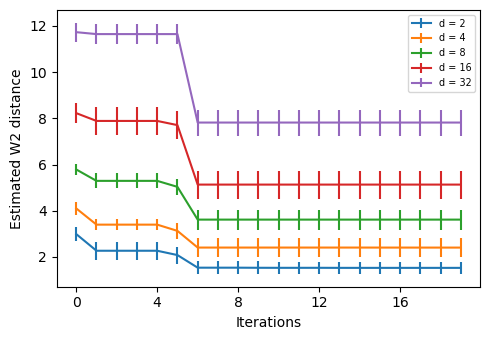

In [7]:
def Gaussian_sampler(index_trail, one_dimen, num_iters, num_chains, Madapt):
    samples = test_nuts6(one_dimen, num_chains, num_iters, Madapt)
    W2_distances = estimate_W2_Gaussian(samples,np.zeros(one_dimen), np.identity(one_dimen)) # the true cov is I_d

    return W2_distances

def test_nuts6(dim, num_chains=50, M=14, Madapt=5):
    """ Example usage of nuts6: sampling a Gaussian distribution with mean zero and identity covariance matrix """

    class Counter:
        def __init__(self, c=0):
            self.c = c

    def normal(theta):
        """
        Target distribution: Gaussian with mean zero and identity covariance matrix.
        """
        A = np.eye(dim)
        counter.c += 1
        grad = -np.dot(theta, A)
        logp = 0.5 * np.dot(grad, theta.T)
        return logp, grad

    all_samples = []
    for chain in range(num_chains):
        counter = Counter()
        D = dim
        diagonal_values = np.linspace(1, 2, D) 
        theta0 = np.random.multivariate_normal( 2 + np.zeros(D), np.diag(diagonal_values), 1)
        theta0 = theta0.ravel()
        delta = 0.2

        samples, lnprob, epsilon = nuts6(normal, M, Madapt, theta0, delta)
        all_samples.append(samples)

    all_samples = np.array(all_samples)
    return all_samples

# Parameters
num_iters = 15
Madapt = 5
trails = 10
num_chains = 50
overall_results = np.zeros([trails, 5, num_iters+Madapt])


for index_trail in range(trails):
    for dim_index, one_dimen in enumerate([2, 4, 8, 16, 32]):
        W2_distances = Gaussian_sampler(index_trail, one_dimen, num_iters, num_chains, Madapt)
        print(f"dim:{one_dimen}, 'W2:{ W2_distances[0]}'")
        overall_results[index_trail, dim_index, :] = W2_distances

# Plot W2 distances
W2_mean = np.mean(overall_results, axis=0)
W2_std = np.std(overall_results, axis=0)
plt.figure(figsize=(5, 3.5))
for dim_index in range(overall_results.shape[1]):
    y = W2_mean[dim_index, :]
    error = 2 * W2_std[dim_index, :]
    one_dimen = 2 ** (dim_index + 1)
    plt.errorbar(list(range(len(y))), y, yerr=error, label=f'd = {one_dimen}')

plt.xlabel('Iterations')
plt.ylabel('Estimated W2 distance')
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.legend(fontsize='x-small')
plt.tight_layout()
plt.savefig('NUTS_W2_dimension.pdf')
plt.show()
plt.close()




L=1.0
min_step_size=0.00014371191339995835
5.60192742275475e-08
adpative sampling
L=1.0
min_step_size=0.00010161966850240442
adpative sampling
6.457351964719388e-08
7.16854238198939e-08
5.997872452225096e-08
L=1.0
min_step_size=7.185595669997918e-05
2.9814274686979855e-07
adpative sampling
1.423214222057462e-07
L=1.0
min_step_size=5.080983425120221e-05
3.467905288519021e-07
adpative sampling
1.1549278077238762e-07
1.1316022232114259e-07
L=1.0
min_step_size=3.592797834998959e-05
adpative sampling
L=1.0
min_step_size=0.00014371191339995835
adpative sampling
3.652374378239604e-08
1.37001969822616e-08
8.307895089495713e-09
L=1.0
min_step_size=0.00010161966850240442
adpative sampling
8.857388936932507e-08
2.685212772407027e-07
2.4306786981839996e-08
4.4744029594923556e-08
1.188528910706408e-07
5.6089237089535253e-08
7.30198733331843e-08
5.5464490673179286e-08
6.725200244011342e-08
L=1.0
min_step_size=7.185595669997918e-05
9.347080220119408e-08
adpative sampling
8.817393479540906e-08
1.95097

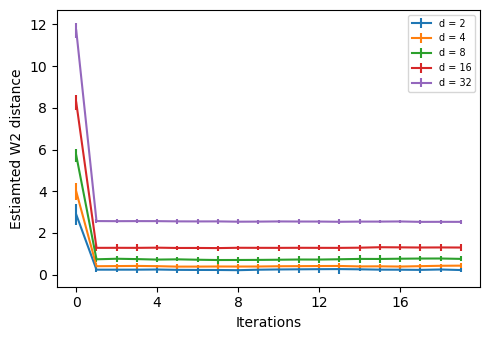

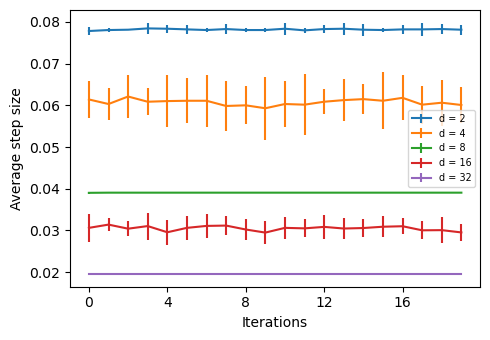

In [8]:
def Gaussian_sampler(seed, dimension, numIter, numSamples, initialStep):

    random.seed(seed)
    np.random.seed(seed)

    Target = target_func(dimension, if_simple = True)
    
    # To Do: double check this formula
    hatC = (1+Target.alpha)*(1/Target.alpha)**(Target.alpha/(1+Target.alpha))*(1/np.pi)**(2/(1+Target.alpha))*2**((-1-2*Target.alpha)/(1+Target.alpha))
    min_step_size = hatC/(120*np.log(6/0.01)/np.log(2)*Target.L_alpha*np.sqrt(Target.dimension))
    print(f"min_step_size={min_step_size}")
        
    Xsamples_adaptive ,step_sizes = proximal_sampler(initialStep, numSamples, numIter, f = Target, fixed = False)
    W2_distances = estimate_W2_Gaussian(Xsamples_adaptive,Target.mean, np.identity(dimension)) # the true cov is I_d

    
    return W2_distances, step_sizes

num_iters = 20
trails = 10
overall_results = np.zeros([trails,5,num_iters])
overall_sizes = np.zeros([trails,5,num_iters])
num_sample = 50

for index_trail in range(trails):
    sizes = np.zeros([5,num_iters])
    for one_dimen in [2,4,8,16,32]:
        W2_distances, step_sizes = Gaussian_sampler(index_trail,one_dimen,num_iters,num_sample,10)
        overall_results[index_trail,int(np.log2(one_dimen)-1),:] =  W2_distances
        overall_sizes[index_trail, int(np.log2(one_dimen)-1),:] = np.mean(step_sizes,axis = 0)
np.save('adaptive_W2.npy',overall_results)
np.save('adaptive_size.npy',overall_sizes)
W2_mean = np.mean(overall_results,axis = 0)
w2_std = np.std(overall_results,axis = 0)
plt.figure(figsize = (5,3.5))
for dimen_index in range(overall_results.shape[1]):
    y = W2_mean[dimen_index,:]
    error = 2* w2_std[dimen_index,:]
    one_dimen = 2**(dimen_index+1)
    plt.errorbar(list(range(len(y))), y, yerr=error, label=f'd = {one_dimen}')

plt.xlabel('Iterations')
plt.ylabel('Estiamted W2 distance')
ax = plt.gca() 
ax.xaxis.set_major_locator(MultipleLocator(4))  
plt.legend(fontsize='x-small')
plt.tight_layout()
plt.savefig('W2_dimension.pdf')
plt.show()
plt.close()


size_mean = np.mean(overall_sizes,axis = 0)
size_std = np.std(overall_sizes,axis = 0)
plt.figure(figsize = (5,3.5))
for dimen_index in range(overall_sizes.shape[1]):
    y = size_mean[dimen_index,:]
    error = 2* size_std[dimen_index,:]
    one_dimen = 2**(dimen_index+1)
    plt.errorbar(list(range(len(y))), y, yerr=error, 
                    label=f'd = {one_dimen}')
plt.xlabel('Iterations')
plt.ylabel('Average step size')
ax = plt.gca() 
ax.xaxis.set_major_locator(MultipleLocator(4))  
plt.legend(fontsize='x-small')
plt.tight_layout()
plt.savefig('step_dimension.pdf')
plt.show()
plt.close()
    